In [1]:
import itertools
import os

import bioframe
import cooler
import cooltools.insulation
import cooltools.lib.plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
from matplotlib.pyplot import flag
from matplotlib.ticker import EngFormatter
from mpl_toolkits.axes_grid import make_axes_locatable
from skimage.filters import threshold_li, threshold_otsu

/users/emma.rusch/.conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


In [2]:
cooler_dir = '/groups/goloborodko/projects/lab/baxterLab2020/results/distiller/coolers_library/'
cooler_file = '190425_HiC_938_cdc20td_cdc20_1b_nextseq.sacCer3.mapq_30.1000.mcool'

resolution = 1000
windows = [10000]

cooler_path = os.path.join(cooler_dir, cooler_file)

In [3]:
def plot_45_mat(ax, clr_mat, start=0, resolution=1000, *args, **kwargs):
    start_pos_vec = [start + resolution * i for i in range(len(clr_mat) + 1)]
    n = clr_mat.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix = np.dot(np.array([(i[1], i[0]) for i in itertools.product(start_pos_vec[::-1], start_pos_vec)]), t)
    x = matrix[:, 1].reshape(n + 1, n + 1)
    y = matrix[:, 0].reshape(n + 1, n + 1)
    img = ax.pcolormesh(x, y, np.flipud(clr_mat), *args, **kwargs)
    img.set_rasterized(True)
    
    return img

In [4]:
def format_ticks(ax, x=True, y=True, rotate=True):
    bp_formatter = EngFormatter('b')
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x', rotation=45)

In [5]:
clr = cooler.Cooler('::/resolutions/'.join((cooler_path, str(resolution))))

chromsizes = bioframe.fetch_chromsizes('sacCer3', filter_chroms=False)
regions = [
    ('chrVI', 0, chromsizes['chrVI'])
]

insulation_score = cooltools.insulation.calculate_insulation_score(clr, windows)
boundaries = cooltools.insulation.find_boundaries(insulation_score)

INFO:numexpr.utils:Note: NumExpr detected 44 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [9]:
test = [1, 2]
for s in zip(windows, test):
    print(s)

(10000, 1)


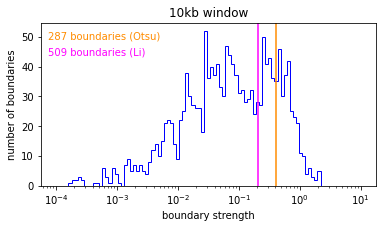

In [22]:
# plot boundaries

fig, axs = plt.subplots(
    len(windows),
    1,
    sharex=True,
    figsize=(6, 3)
)

if len(windows) == 1:
    axs = [axs]

histkwargs = dict(bins=10 ** np.linspace(-4, 1, 100), histtype="step", lw=1, color='blue')

for w, ax in zip(windows, axs):
    ax.hist(boundaries[f'boundary_strength_{w}'], **histkwargs)
    ax.set(xscale='log', ylabel='number of boundaries')

    th_li = threshold_li(boundaries[f"boundary_strength_{w}"].dropna().values)
    th_otsu = threshold_otsu(
        boundaries[f"boundary_strength_{w}"].dropna().values
    )
    n_boundaries_li = (
        boundaries[f"boundary_strength_{w}"].dropna() >= th_li
    ).sum()
    n_boundaries_otsu = (
        boundaries[f"boundary_strength_{w}"].dropna() >= th_otsu
    ).sum()

    ax.axvline(th_otsu, c="darkorange")
    ax.axvline(th_li, c="magenta")

    ax.text(
        0.02,
        0.95,
        f"{n_boundaries_otsu} boundaries (Otsu)",
        c="darkorange",
        ha="left",
        va="top",
        transform=ax.transAxes,
    )
    ax.text(
        0.02,
        0.85,
        f"{n_boundaries_li} boundaries (Li)",
        c="magenta",
        ha="left",
        va="top",
        transform=ax.transAxes,
    )

    ax.set_title(f'{w // 1000}kb window')

ax.set_xlabel('boundary strength');

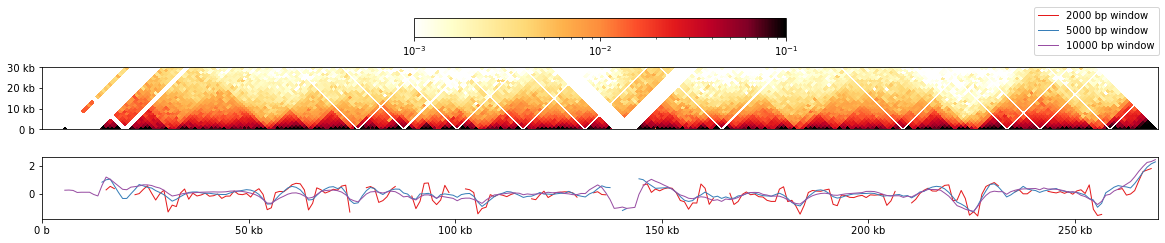

In [95]:
# plot insulation scores

for region in regions:
    norm = LogNorm(vmax=0.1, vmin=0.001)
    data = clr.matrix(balance=True).fetch(region)
    fig, ax = plt.subplots(figsize=(20, 4))

    img = plot_45_mat(ax, data, start=0, resolution=resolution, norm=norm, cmap='fall')
    divider = make_axes_locatable(ax)

    ax.set_aspect(0.5)
    ax.set_ylim(ymin=0, ymax=30000)
    format_ticks(ax, rotate=False)
    ax.xaxis.set_visible(False)

    insul_region = bioframe.select(insulation_score, region)
    
    ins_ax = divider.append_axes('bottom', size='50%', pad=-0.05, sharex=ax)
    ins_ax.set_prop_cycle(plt.cycler('color', plt.cm.Set1(np.linspace(0, 1, 6))))

    for window in windows:
        ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{window}'],
            label=f'{window} bp window', lw=1)

    if True:
        cax = divider.append_axes('top', size='15%', pad=0.0, aspect=0.05)
        plt.colorbar(img, cax=cax, orientation='horizontal')
        ins_ax.legend(bbox_to_anchor=(1.005, 3.5), loc='upper right')

    #ax.set_title('chrV', loc='left')

    format_ticks(ins_ax, y=False, rotate=False)
    ax.set_xlim(region[1], region[2])
    
    plt.show()
#    fig.suptitle(f'{title}: {region[0]}')